In [1]:
import os
import re
from collections import defaultdict
from functools import reduce
import matplotlib.pyplot as plt

In [69]:
class SpamFilter:
    def __init__(self, spamicityrate, N, threshold):
        self.lexeme_spam_counts = {}
        self.lexeme_ham_counts = {}
        self.all_counts = defaultdict(lambda: [0, 0])
        self.lexeme_spamicity_probabilities = {}
        self.spamicityrate = spamicityrate
        self.N = N
        self.threshold = threshold
        
    def occurrences(self, folder_path):
    # Iterate over files in the folder
        lexeme_counts = defaultdict(int)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                    # Read the file content
                    content = file.read()

                    # Tokenize the content into words (lexemes)
                    words = re.findall(r'\b\w+\b', content.lower())

                    # Count the occurrences of each lexeme
                    for word in words:
                        lexeme_counts[word] += 1  # Increment SPAM count

        return lexeme_counts
    
    def count_occurrences(self, spam_path, ham_path):
        # Count occurrences in the SPAM folder
        self.lexeme_spam_counts= self.occurrences(spam_folder)

        # Count occurrences in the HAM folder
        self.lexeme_ham_counts= self.occurrences(ham_folder)

        # Merge lexeme counts for SPAM and HAM into a single dictionary
       
        for lexeme, counts in self.lexeme_spam_counts.items():
            self.all_counts[lexeme][0] += counts  # Update SPAM count

        for lexeme, counts in self.lexeme_ham_counts.items():
            self.all_counts[lexeme][1] += counts  # Update HAM count

    def print_a_lexeme(self, lexeme_to_print):
        if lexeme_to_print in self.all_counts:
            spam_count = self.all_counts[lexeme_to_print][0]
            ham_count = self.all_counts[lexeme_to_print][1]
            print(f"Lexeme: {lexeme_to_print}")
            print(f"SPAM Count: {spam_count}")
            print(f"HAM Count: {ham_count}")
            probability = self.lexeme_spamicity_probabilities[lexeme_to_print]
            print(f"Spamicity: {probability:.2f}")


    def calculate_spamicity_probability(self):
        # Step 1: Calculate total number of lexemes in SPAM and HAM
        total_spam_lexemes = sum(counts[0] for counts in self.all_counts.values())
        total_ham_lexemes = sum(counts[1] for counts in self.all_counts.values())

        # Step 2: Calculate P(lexeme|SPAM) for each lexeme
        lexeme_spam_probabilities = {}
        for lexeme, counts in self.all_counts.items():
            spam_count = counts[0]
            lexeme_spam_probabilities[lexeme] = spam_count / total_spam_lexemes

        # Step 3: Calculate P(lexeme|HAM) for each lexeme
        lexeme_ham_probabilities = {}
        for lexeme, counts in self.all_counts.items():
            ham_count = counts[1]
            lexeme_ham_probabilities[lexeme] = ham_count / total_ham_lexemes

        # Step 4: Calculate P(SPAM|lexeme) for each lexeme  
        for lexeme in self.all_counts.keys():
            # Boundary cases
            if lexeme_spam_probabilities[lexeme] == 0:
                self.lexeme_spamicity_probabilities[lexeme] = 0.01
            elif lexeme_ham_probabilities[lexeme] == 0:
                self.lexeme_spamicity_probabilities[lexeme] = 0.99
            else:
                self.lexeme_spamicity_probabilities[lexeme] = lexeme_spam_probabilities[lexeme] / (lexeme_spam_probabilities[lexeme] + lexeme_ham_probabilities[lexeme])



    def classify_file(self,file_path): 
        encodings = ['utf-8', 'latin-1']  # Add more encodings if needed

        # Try different encodings to open the file and count lexeme occurrences
        for encoding in encodings:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    content = file.read()
                # Tokenize the content into words (lexemes)
                    words = re.findall(r'\b\w+\b', content.lower())

                    new_file_spamicity = {}
                    for word in words:
                        if word in self.lexeme_spamicity_probabilities:
                            new_file_spamicity[word] = self.lexeme_spamicity_probabilities[word]
                        else:
                            new_file_spamicity[word] = self.spamicityrate
                break  # Break the loop if the file is read successfully with an encoding
            except UnicodeDecodeError:
                    continue

        # Mean spamicity
        spamicity = self.lexeme_spamicity_probabilities.values()
        mean_spamicity = sum(spamicity) / len(spamicity)

        # Calculate distances from the mean for each lexeme
        new_file_spamicity_distances = {}
        for lexeme in new_file_spamicity:
            lexeme_spamicity = new_file_spamicity[lexeme]
            distance_from_mean = abs(lexeme_spamicity - mean_spamicity)
            new_file_spamicity_distances[lexeme] = distance_from_mean

        # Sort the new_file_spamicity_distances dictionary by distances in descending order
        sorted_lexemes = sorted(new_file_spamicity_distances, key=new_file_spamicity_distances.get, reverse=True)

        # Select the N lexemes with the largest distances from the mean spamicity
        selected_lexemes = sorted_lexemes[:self.N]

        dividor = reduce(lambda x, y: x * y, [new_file_spamicity[lexeme] for lexeme in selected_lexemes], 1)

        divident = dividor + reduce(lambda x, y: x * y, map(lambda lexeme: 1 - new_file_spamicity[lexeme], selected_lexemes))
        probability = dividor / divident

        if probability >= self.threshold:
            return 'SPAM'
        else:
            return 'HAM'
            
  
    def evaluate_performance(self, spam_test_folder_path, ham_test_folder_path, printt):
        spam_files_total = len(os.listdir(spam_test_folder_path))
        ham_files_total = len(os.listdir(ham_test_folder_path))
        spam_files_as_ham = 0
        ham_files_as_spam = 0
        correctly_classified_files = 0

        # Classify SPAM files in the SPAM test folder
        for file_name in os.listdir(spam_test_folder_path):
            file_path = os.path.join(spam_test_folder_path, file_name)
            classification_result = self.classify_file(file_path)

            if classification_result == 'HAM':
                spam_files_as_ham += 1
            else:
                correctly_classified_files += 1

        # Classify HAM files in the HAM test folder
        for file_name in os.listdir(ham_test_folder_path):
            file_path = os.path.join(ham_test_folder_path, file_name)
            classification_result = self.classify_file(file_path)

            if classification_result == 'SPAM':
                ham_files_as_spam += 1
            else:
                correctly_classified_files += 1

        # Calculate the ratios and print the metrics
        false_positive_ratio = spam_files_as_ham / spam_files_total * 100
        false_negative_ratio = ham_files_as_spam / ham_files_total * 100
        correctly_classified_ratio = correctly_classified_files / (spam_files_total + ham_files_total) * 100
        
        if printt:
            print("Number of SPAM files classified as HAM (false positive):", spam_files_as_ham)
            print("Number of HAM files classified as SPAM (false negative):", ham_files_as_spam)
            print("Ratio of correctly classified files (%):", correctly_classified_ratio)

        return [correctly_classified_ratio, spam_files_as_ham, ham_files_as_spam]

        
    

In [3]:
current_directory = os.getcwd()

# Folder paths for SPAM and HAM folders
spam_folder = os.path.join(current_directory, 'SPAM')
ham_folder = os.path.join(current_directory, 'HAM')

NewSpamFilter = SpamFilter(0.4, 2, 0.5)
NewSpamFilter.count_occurrences(spam_folder, ham_folder)

In [4]:
NewSpamFilter.calculate_spamicity_probability()
lexeme_to_print = 'section1'  

NewSpamFilter.print_a_lexeme(lexeme_to_print)


Lexeme: section1
SPAM Count: 12
HAM Count: 0
Spamicity: 0.99


In [19]:
def test_with_spamicity_value(values):
    current_directory = os.getcwd()

    # Folder paths for SPAM and HAM folders
    spam_folder = os.path.join(current_directory, 'SPAM')
    ham_folder = os.path.join(current_directory, 'HAM')
    performances = []
    falsepositive =[]
    falsenegative = []
    for spamicityvalue in values:
        # Training the model with data
        NewSpamFilter = SpamFilter(spamicityvalue, 2, 0.5)
        NewSpamFilter.count_occurrences(spam_folder, ham_folder)
        NewSpamFilter.calculate_spamicity_probability()

        spam_test_folder = os.path.join(current_directory, 'testspam')
        ham_test_folder = os.path.join(current_directory, 'testnotspam')

        result = NewSpamFilter.evaluate_performance(spam_test_folder, ham_test_folder, False)
        
        performances.append(result[0])
        falsepositive.append(result[1])
        falsenegative.append(result[2])

    return performances, falsepositive, falsenegative

In [70]:
values = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)
result = test_with_spamicity_value(values)

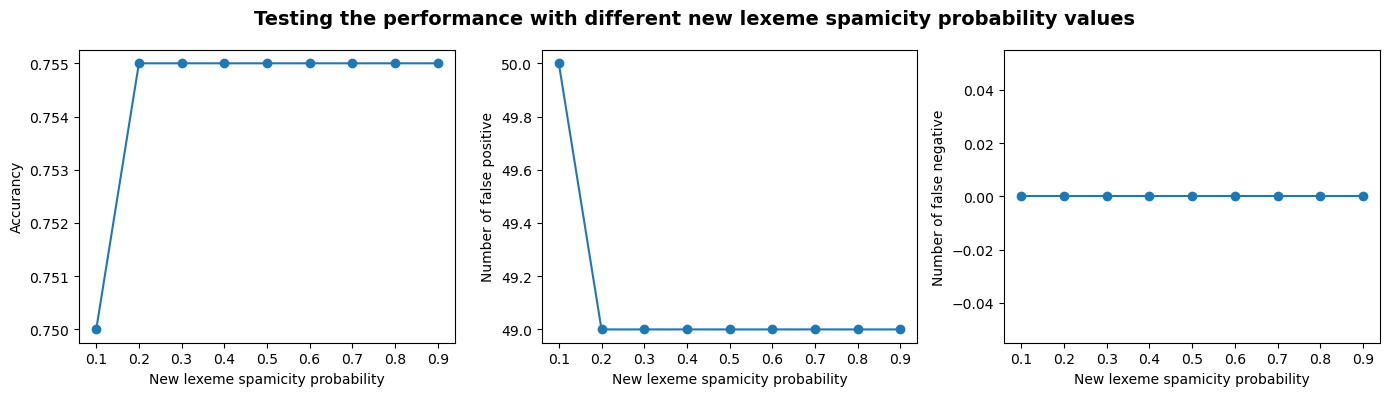

In [71]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].plot(values, result[0], '-o')
axes[0].set_xlabel('New lexeme spamicity probability')
axes[0].set_ylabel('Accurancy')

axes[1].plot(values, result[1], '-o')
axes[1].set_xlabel('New lexeme spamicity probability')
axes[1].set_ylabel('Number of false positive')

axes[2].plot(values, result[2], '-o')
axes[2].set_xlabel('New lexeme spamicity probability')
axes[2].set_ylabel('Number of false negative')

fig.suptitle('Testing the performance with different new lexeme spamicity probability values', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



In [47]:
def test_with_N(values):
    current_directory = os.getcwd()
    # Folder paths for SPAM and HAM folders
    spam_folder = os.path.join(current_directory, 'SPAM')
    ham_folder = os.path.join(current_directory, 'HAM')
    performances = []
    falsepositive =[]
    falsenegative = []
    for N in values:
        # Training the model with data
        NewSpamFilter = SpamFilter(0.4, N, 0.5)
        NewSpamFilter.count_occurrences(spam_folder, ham_folder)
        NewSpamFilter.calculate_spamicity_probability()

        spam_test_folder = os.path.join(current_directory, 'testspam')
        ham_test_folder = os.path.join(current_directory, 'testnotspam')

        result = NewSpamFilter.evaluate_performance(spam_test_folder, ham_test_folder, False)
        
        performances.append(result[0])
        falsepositive.append(result[1])
        falsenegative.append(result[2])

    return performances, falsepositive, falsenegative

In [50]:
values = (2,4,16,32,64,128)
result = test_with_N(values)

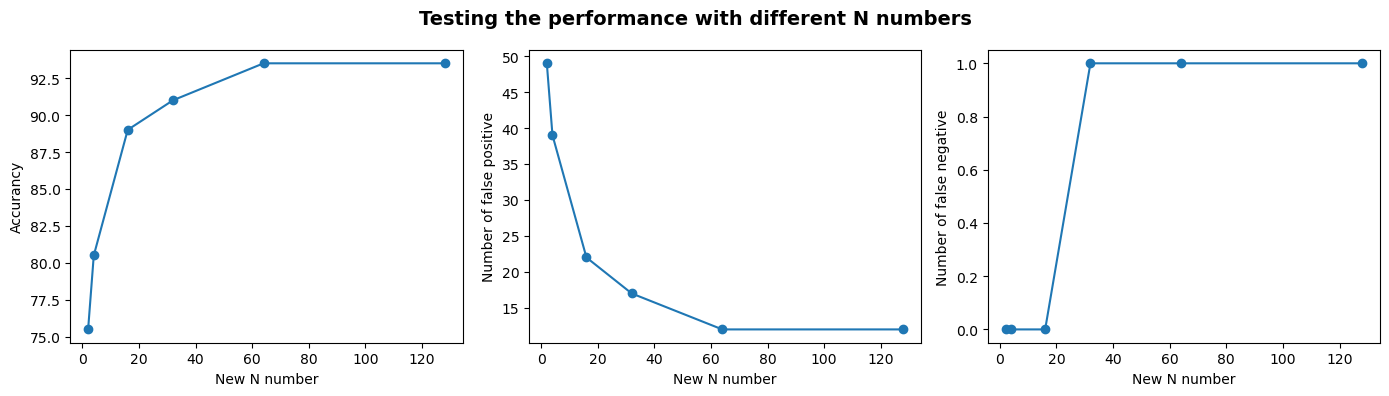

In [51]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

axes[0].plot(values, result[0], '-o')
axes[0].set_xlabel('New N number')
axes[0].set_ylabel('Accurancy')

axes[1].plot(values, result[1], '-o')
axes[1].set_xlabel('New N number')
axes[1].set_ylabel('Number of false positive')

axes[2].plot(values, result[2], '-o')
axes[2].set_xlabel('New N number')
axes[2].set_ylabel('Number of false negative')

fig.suptitle('Testing the performance with different N numbers', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



In [52]:
def test_with_threshold(values):
    current_directory = os.getcwd()
    # Folder paths for SPAM and HAM folders
    spam_folder = os.path.join(current_directory, 'SPAM')
    ham_folder = os.path.join(current_directory, 'HAM')
    performances = []
    falsepositive =[]
    falsenegative = []
    for threshold in values:
        # Training the model with data
        NewSpamFilter = SpamFilter(0.4, 2, threshold)
        NewSpamFilter.count_occurrences(spam_folder, ham_folder)
        NewSpamFilter.calculate_spamicity_probability()

        spam_test_folder = os.path.join(current_directory, 'testspam')
        ham_test_folder = os.path.join(current_directory, 'testnotspam')

        result = NewSpamFilter.evaluate_performance(spam_test_folder, ham_test_folder, False)
        
        performances.append(result[0])
        falsepositive.append(result[1])
        falsenegative.append(result[2])

    return performances, falsepositive, falsenegative

In [53]:
values = (0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)
result = test_with_threshold(values)

In [68]:
# Creating the model with the best performing parameters
NewSpamFilter = SpamFilter(0.4, 64, 0.01)
# Training the model
NewSpamFilter.count_occurrences(spam_folder, ham_folder)
NewSpamFilter.calculate_spamicity_probability()

# Test folders
spam_test_folder = os.path.join(current_directory, 'testspam')
ham_test_folder = os.path.join(current_directory, 'testnotspam')

print('Best performance: ')
NewSpamFilter.evaluate_performance(spam_test_folder, ham_test_folder, True)

Best performance: 
Number of SPAM files classified as HAM (false positive): 10
Number of HAM files classified as SPAM (false negative): 1
Ratio of correctly classified files (%): 94.5


[94.5, 10, 1]